In [18]:
%load_ext autoreload
%autoreload 2

import os
import sys

from  GRU import GRUEncoderGD, GRUDecoderGD
from TPDN import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

# def precision(predicted, target):
#     correct = (predicted.argmax(dim=-1) == target).float()
#     return correct.mean().item() * 100

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))
    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')
    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
input_size = 10
emb_size = 8
hidden_size = 64

output_size = 10
num_layers = 1
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision= Accuracy(task="multiclass", num_classes=input_size).to(device) 

encoder = torch.load( "gru_enc.pth").to(device)
decoder = torch.load( "gru_dec.pth").to(device)

tpdnencoder = torch.load( "tpdn_gru.pth").to(device)

/tmp/ipykernel_7139/2771208600.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load( "gru_enc.pth").to(device)
/tmp/ipykernel_7139/2771208600.py:17: Fut

torch.Size([1, 10, 64])
torch.Size([1, 1, 64])
torch.Size([1, 64])
torch.Size([1, 10, 64])
tensor([[ 0.1596,  0.6322,  0.3950,  0.5297, -0.2396,  0.9832,  0.3590, -0.1303,
         -0.6411, -0.2081, -0.5288,  0.9877,  0.2897, -0.0333, -0.6486, -0.6781,
          0.2880, -0.9614,  0.9705,  0.4820,  0.8576,  0.4731, -0.9070,  0.8767,
          0.2141, -0.2763,  0.1820,  0.9367, -0.4379,  0.4710,  0.2433,  0.7274,
         -0.1389, -0.9105,  0.4475,  0.1905, -0.5258,  0.1682, -0.3957,  0.5775,
         -0.4865,  0.0062,  0.9371,  0.0875, -0.9604,  0.2250, -0.1551,  0.3268,
          0.1410,  0.4333, -0.8237, -0.3456,  0.5638, -0.2438, -0.7108, -0.4915,
         -0.3199,  0.7352, -0.2984, -0.4702,  0.8633, -0.3093,  0.1966, -0.1199]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.3541,  0.7710,  0.3420,  0.2855, -0.1200,  0.9496,  0.4294, -0.0968,
         -0.5856,  0.1482, -0.2851,  0.9985,  0.2251, -0.5296, -0.2704, -0.5891,
          0.6077, -0.6045,  0.9711,  0.1733,  

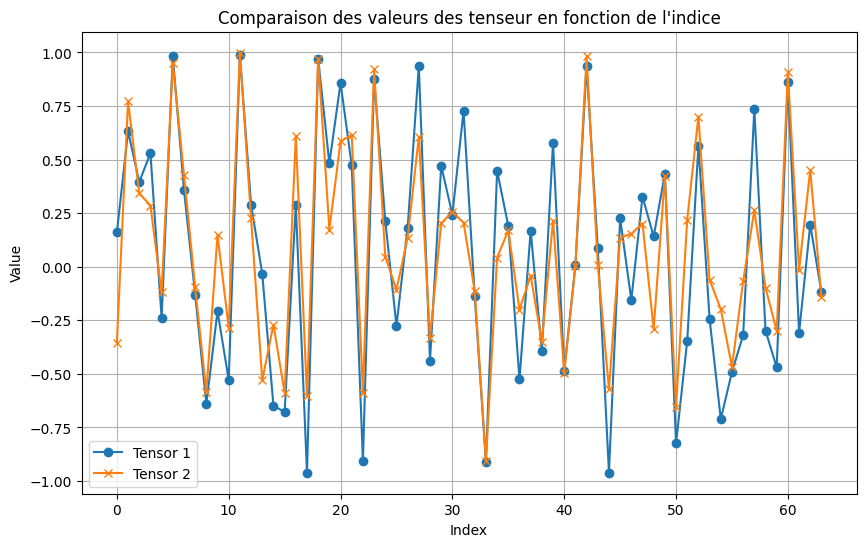

In [27]:
data , roles = generate_data(1, seq_len, input_size)
data = data.to(device)
roles = roles.to(device)
rnn_out, rnn_hidden = encoder(data)
tpdn_output= tpdnencoder(data, roles)
# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:]

print( rnn_out.shape)
print(rnn_hidden.shape)
print(tpdn_hidden.shape)
print(tpdn_output.shape)

print(rnn_hidden[-1])
print(tpdn_hidden)
plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

In [34]:
data , roles = generate_data(1, seq_len, input_size)
data = data.to(device)
roles = roles.to(device)
print(data)

rnn_out, rnn_hidden = encoder(data)
rnn_hidden = rnn_hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1)
tpdn_output= tpdnencoder(data, roles)

# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:].repeat(num_layers, 1, 1).to(device)
# encoder_hidden = rnn_hidden[-1,:,:]
# print( rnn_hidden.shape)
# print(tpdn_hidden.shape)
print()
print(decoder(rnn_hidden, seq_len).argmax(dim=-1).shape)
print(data.shape)
print(decoder(rnn_hidden, seq_len).argmax(dim=-1))
# print(decoder(rnn_hidden, seq_len).view(-1, output_size))
print(decoder(tpdn_hidden, seq_len).argmax(dim=-1))

print( precision(decoder(rnn_hidden, seq_len).argmax(dim=-1),data))

print( precision(decoder(tpdn_hidden, seq_len).argmax(dim=-1),data))

tensor([[7, 2, 1, 2, 3, 9, 6, 5, 7, 6]], device='cuda:0')

torch.Size([1, 10])
torch.Size([1, 10])
tensor([[7, 2, 1, 2, 3, 9, 6, 5, 7, 6]], device='cuda:0')
tensor([[1, 3, 6, 4, 0, 3, 8, 4, 6, 6]], device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.1000, device='cuda:0')
